In [1]:
import torch
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('cuda devices:', torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f'\t{torch.cuda.get_device_properties(i).name}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
torch.set_default_device(device)
dtype = torch.float
torch.set_default_dtype(dtype)

cuda devices: 1
	AMD Radeon RX 6750 XT


In [3]:
class Camera:
    def __init__(self, pos, u, v, w, focal_length, size, render_distance, resolution):
        self.pos = pos
        # orthonormal basis for camera POV
        self.u = u  # left
        self.v = v  # up
        self.w = w  # forward (viewing direction)
        self.d = focal_length  # distance from pos to pixels
        self.size = size
        self.max_dist = render_distance;
        self.res = resolution

    def pixel_pos(self, i, j):
        width, height = self.res
        w_ratio = width / max(width, height)
        h_ratio = height / max(width, height)
        if i < 0 or j < 0 or i >= width or j >= height:
            raise IndexError('Pixel out of bounds')
        return self.pos + self.d * self.w \
                        + w_ratio * self.size / 2 * (i / width - 0.5) * self.u \
                        + h_ratio * self.size / 2 * (j / height - 0.5) * self.v

    def pixel_dir(self, i, j):
        dir = self.pixel_pos(i, j) - self.pos
        return dir / dir.norm()

    def index(self, i, j):
        width, height = self.res
        return i * height + j

    def all_pixel_dirs(self):
        width, height = self.res
        dirs = torch.zeros((width * height, 3))
        for i in range(width):
            for j in range(height):
                dirs[self.index(i, j), :] = self.pixel_dir(i, j)
        return dirs


In [4]:
class BlenderDefaultCamera(Camera):
    def __init__(self, pos, u, v, w):
        super().__init__(pos, u, v, w, 0.005, 0.036, 50, (25, 25))

class BlenderOrbitCamera(BlenderDefaultCamera):
    def __init__(self, pos):
        u, v, w = camera_dir_from_pos(pos)
        super().__init__(pos, u, v, w)

In [5]:
def camera_dir_from_pos(pos):
    x, y, z = pos
    x_angle = np.pi / 2 - torch.arctan2(z, torch.sqrt(x ** 2 + y ** 2))
    z_angle = np.pi / 2 + torch.arctan2(y, x)
    rotation = R.from_euler('xyz', [x_angle, 0, z_angle])
    M = torch.from_numpy(rotation.as_matrix()).float()
    return (M[:, 0], M[:, 1], M[:, 2])

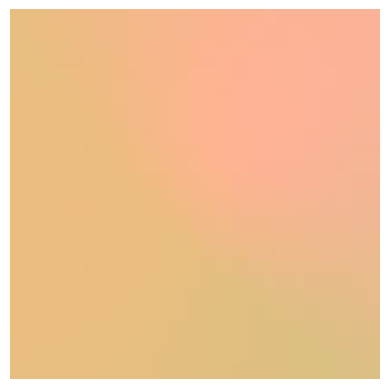

In [6]:
class NeRF(torch.nn.Module):
    def __init__(self, training_dir):
        super().__init__()
        self.layer_size = 2
        size = self.layer_size
        self.d1 = torch.nn.Sequential(
            torch.nn.Linear(3, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size),
            torch.nn.ReLU()
        )
        self.d2 = torch.nn.Sequential(
            torch.nn.Linear(size + 3, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, size + 1),
            torch.nn.ReLU()
        )
        self.c = torch.nn.Sequential(
            torch.nn.Linear(size + 3, size),
            torch.nn.ReLU(),
            torch.nn.Linear(size, 3),
            torch.nn.Sigmoid()
        )

        self.dir = training_dir
        self.camera_positions = torch.from_numpy(np.genfromtxt(f'{self.dir}/coords.csv', delimiter=',')).float()


    def get_camera_for_pos(i):
        return BlenderOrbitCamera(self.camera_positions[i, :])


    def forward(self, input):
        x = input[:, :3]
        dir = input[:, 3:]
        curr = self.d1(x)
        curr = torch.hstack((curr, x))
        curr = self.d2(curr)
        density = curr[:, -1].unsqueeze(1)
        curr = torch.hstack((curr[:, :-1], dir))
        curr = self.c(curr)
        output = torch.hstack((density, curr))
        return output


    def render(self, camera, samples_per_ray):
        width, height = camera.res
        pixels = torch.zeros((width * height, 3), requires_grad=True)
        h = camera.max_dist / samples_per_ray
        origins = torch.tile(camera.pos, (width * height, 1)).to(device)
        dirs = camera.all_pixel_dirs().to(device)
        prev_t = 0
        density_so_far = torch.zeros((width * height,))
        # it = 0
        for s in torch.arange(0, camera.max_dist, h):
            t = s + torch.rand((1,)) * h
            x = origins + t * dirs
            
            input = torch.hstack((x, dirs))

            # HERE -------------------------------
            p = self(input)
            # HERE -------------------------------

            delta = (t - prev_t)

            density = p[:, 0]
            colour = p[:, 1:]
            # print(colour)

            density_so_far = density_so_far + delta * density
            T = torch.exp(-density_so_far)
            alpha = 1 - torch.exp(-delta * density)

            pixels = pixels + (T * alpha).unsqueeze(1) * colour
            
            prev_t = t

        return pixels.reshape((width, height, 3))


    def view_image(self, camera, samples_per_ray=10):
        rgb_img_torch = self.render(camera, samples_per_ray)
        rgb_img_torch = rgb_img_torch / rgb_img_torch.max()
        # rgb_img_torch = torch.softmax(rgb_img_torch, axis=2)
        # print(rgb_img_torch)
        rgb_img_cpu = rgb_img_torch.cpu().detach().numpy()
        plt.axis('off')
        plt.imshow(rgb_img_cpu)

model = NeRF('./cube_25x25')
ex = torch.tensor([1, 0, 0])
ey = torch.tensor([0, 1, 0])
ez = torch.tensor([0, 0, 1])
c = BlenderDefaultCamera(pos=-ez, u=ex, v=ey, w=ez)
model.view_image(c)

In [7]:
for param in model.named_parameters():
    print(param)

('d1.0.weight', Parameter containing:
tensor([[-0.4308, -0.0717,  0.4423],
        [ 0.0277, -0.0765,  0.4242]], requires_grad=True))
('d1.0.bias', Parameter containing:
tensor([-0.3822,  0.3989], requires_grad=True))
('d1.2.weight', Parameter containing:
tensor([[ 0.5166, -0.6854],
        [ 0.4168,  0.3359]], requires_grad=True))
('d1.2.bias', Parameter containing:
tensor([-0.1747,  0.6408], requires_grad=True))
('d1.4.weight', Parameter containing:
tensor([[ 0.3245, -0.1958],
        [-0.7033, -0.1411]], requires_grad=True))
('d1.4.bias', Parameter containing:
tensor([-0.2248, -0.6863], requires_grad=True))
('d1.6.weight', Parameter containing:
tensor([[ 0.1764, -0.0230],
        [-0.1336,  0.2654]], requires_grad=True))
('d1.6.bias', Parameter containing:
tensor([-0.6094,  0.2232], requires_grad=True))
('d2.0.weight', Parameter containing:
tensor([[-0.1763,  0.1318, -0.4430,  0.3869, -0.2371],
        [ 0.3320, -0.2583, -0.1372,  0.0276, -0.1792]], requires_grad=True))
('d2.0.bias'

In [8]:
C = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
d = torch.tensor([0.1, 0.2, 0.3]).unsqueeze(1)
d * C

tensor([[0.1000, 0.2000, 0.3000],
        [0.8000, 1.0000, 1.2000],
        [2.1000, 2.4000, 2.7000]])

In [9]:
model = NeRF('./cube_25x25')

In [10]:
model = NeRF('./cube_25x25')
N, _ = model.camera_positions.size()
block_size = 10

learning_rate = 1
# loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for k in range(5):
    print(f'{k}----------------')
    for j in range(N // block_size):
        print(f'{j}\t', end='')
        running_loss = torch.zeros(1, requires_grad=True)
        for i in range(j * block_size, min((j + 1) * block_size, N)):
            print(f'{i} ', end='')
            cam = BlenderOrbitCamera(pos = model.camera_positions[i,:])
            gt_img = read_image(f'{model.dir}/{i}.png')[:3,:].permute(1, 2, 0).float().to(device)
            gen_img = model.render(cam, 100)
            
            # loss = loss_fn(gt_img, gen_img)
            loss = (gt_img - gen_img).norm() ** 2
            running_loss = running_loss + loss

        optimizer.zero_grad()
        print()
        running_loss.backward()
        print(f'\n\t{running_loss.item()}\n\t')
        befores = []
        for param in model.parameters():
            print(f' {param.grad.norm()}', end=' ')
            befores.append(param.data.clone())
        print()
        optimizer.step()
        c = 0
        for param in model.parameters():
            print(f' {(param.data - befores[c]).norm()}', end='')
            c += 1
        print()


0----------------
0	0 1 2 3 4 5 6 7 8 9 

	15559161.0
	
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
1	10 11 12 13 14 15 16 17 18 19 

	8638081.0
	
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
2	20 21 22 23 24 25 26 27 28 29 

	11353824.0
	
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
3	30 31 32 33 34 35 36 37 38 39 

	13035357.0
	
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
4	40 41 42 43 44 45 46 47 48 49 

	10276810.0
	
 0.0  0.0  0.0  0.0  0.0 

5.3945937 0.0


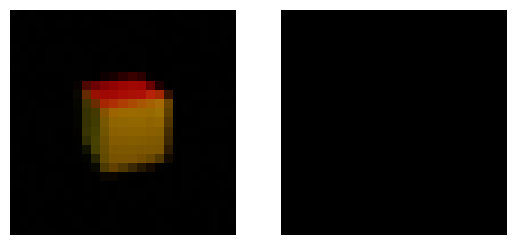

In [13]:
i=1
pos = model.camera_positions[i,:]
u, v, w = camera_dir_from_pos(pos)
cam = BlenderDefaultCamera(pos, u, v, w)
gt_img = read_image(f'{model.dir}/{i}.png')[:3,:].permute(1, 2, 0).float() / 255
gen_img = model.render(cam, 100)

gt_img_cpu = gt_img.cpu().detach().numpy()
gen_img_cpu = gen_img.cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(gt_img_cpu)
ax2.imshow(gen_img_cpu)

print(np.linalg.norm(gt_img_cpu), np.linalg.norm(gen_img_cpu))